In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image

from random import randint
import random
from IPython.display import Image
from IPython.core.display import Image, display

from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = '/scratch/sa5154/ssl_data_96'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def load_data(data_dir, batch_size, split):
    """ Method returning a data loader for labeled data """
    # TODO: add data transformations if needed
    transform = transforms.Compose([
        transforms.ToTensor()
        ]
    )
    data = datasets.ImageFolder(f'{data_dir}/supervised/{split}', transform=transform)
    data_loader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    return data_loader

In [5]:
def load_unsuper_data(data_dir, batch_size):
    """ Method returning a data loader for labeled data """
    # TODO: add data transformations if needed
    transform = transforms.Compose([
#         transforms.Resize(64),
        transforms.ToTensor()
        ]
    )
    data = datasets.ImageFolder(f'{data_dir}/unsupervised/', transform=transform)
    data_loader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    return data_loader

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
 class UnFlatten(nn.Module):
    def forward(self, input, size=4096):
        return input.view(input.size(0), size, 1, 1)

In [21]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=4096, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 1024, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        std.to(device)
        mu.to(device)
        # return torch.normal(mu, std)
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
#         esp = torch.randn(*mu.size())
#         esp.to(device)
#         z = mu + std * esp
#         return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        mu.to(device)
        logvar.to(device)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
#         print("Printing shape of encoded vector:")
#         print(h.shape)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
train_data = load_data(data_dir, 32, 'train')
unsupervised_data = load_unsuper_data(data_dir, 32)

In [25]:
model = VAE().to(device)

In [11]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 10
iter_ = 0
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    train_loss = 0
    iter_=0
    for x, _ in unsupervised_data:
        iter_+=1
        
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
        loss = loss_fn(x_hat, x, mu, logvar)
        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(iter_ %100 == 0):
            print(f'====> Iter: {iter_} Epoch: {epoch} Average loss: {train_loss / iter_:.4f}')
    # ===================log========================
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(unsupervised_data):.4f}')
    
#     # Testing
    
#     with torch.no_grad():
#         model.eval()
#         test_loss = 0
#         for x, _ in test_loader:
#             x = x.to(device)
#             # ===================forward=====================
#             x_hat, mu, logvar = model(x)
#             test_loss += loss_function(x_hat, x, mu, logvar).item()
#     # ===================log========================
#     test_loss /= len(test_loader.dataset)
#     print(f'====> Test set loss: {test_loss:.4f}')
#     display_images(x, x_hat, 1, f'Epoch {epoch}')

====> Iter: 100 Epoch: 1 Average loss: 581217.2575
====> Iter: 200 Epoch: 1 Average loss: 556001.8550
====> Iter: 300 Epoch: 1 Average loss: 544183.7906
====> Iter: 400 Epoch: 1 Average loss: 537038.8070
====> Iter: 500 Epoch: 1 Average loss: 532254.8576
====> Iter: 600 Epoch: 1 Average loss: 528709.3510
====> Iter: 700 Epoch: 1 Average loss: 525938.4268
====> Iter: 800 Epoch: 1 Average loss: 523047.3182
====> Iter: 900 Epoch: 1 Average loss: 520717.6249
====> Iter: 1000 Epoch: 1 Average loss: 518255.9948
====> Iter: 1100 Epoch: 1 Average loss: 516250.9076
====> Iter: 1200 Epoch: 1 Average loss: 514893.7685
====> Iter: 1300 Epoch: 1 Average loss: 513440.8361
====> Iter: 1400 Epoch: 1 Average loss: 512088.3664
====> Iter: 1500 Epoch: 1 Average loss: 510973.5323
====> Iter: 1600 Epoch: 1 Average loss: 510025.0267
====> Iter: 1700 Epoch: 1 Average loss: 509030.4957
====> Iter: 1800 Epoch: 1 Average loss: 507957.0132
====> Iter: 1900 Epoch: 1 Average loss: 507316.0578
====> Iter: 2000 Epoc

In [ ]:
for x, _ in unsupervised_data:
        iter_+=1
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
        loss = loss_fn(x_hat, x, mu, logvar)
        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(unsupervised_data):.4f}')
        break

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
#         img0 = img0.convert("L")
#         img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    

In [5]:
transform = transforms.Compose([
        transforms.ToTensor()
        ]
    )
data = datasets.ImageFolder(f'{data_dir}/supervised/train')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=data,
                                        transform=transform
                                       ,should_invert=False)

In [6]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

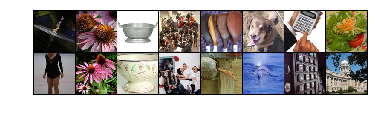

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())